In [2]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

BDC is using numpy


In [3]:
#spectrum interval (aka period) (4096 point FFT, 250M sampling rate)
T_SPECTRA = 4096/250e6

#start and end times

start_file_time = 1721800002
t_start = start_file_time
t_end = t_start+3600

#use "get_init_info" to get the files and spectrum numbers needed for our time interval
a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"
files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)
print(files_a1)
print(files_a2)
initial_specnum_offset = idx1-idx2
print("Initial Spectrum Number Offset:", initial_specnum_offset)

#get channel indices between 1834 and 1854, where we think we will find satellites
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
#total number of channels
nchans=chanend-chanstart

#set accumulation lengths for coarse and visibilities (spectra per chunk)
c_acclen = 10**6 
acclen = 30* 10**3 
print(c_acclen, acclen)

# accumulation length periods (integration time) and total number chunks
T_ACCLEN = acclen * 4096/250e6
T_C_ACCLEN = c_acclen * 4096/250e6
nchunks = int((t_end-t_start)/T_ACCLEN)




['/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800002.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800047.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800091.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800135.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800180.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800224.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800269.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800313.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800357.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800402.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800446.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800490.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800535.raw', '/scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/17218005

In [4]:
#bullshit magic plot armour to get the idx correction

idx_correction=109993-100000
if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)
print("Corrected Starting Indices:", idx1, idx2)

Corrected Starting Indices: 9993 1708984


In [5]:
ant1=bdc.BasebandFileIterator(files_a1, 0, idx1, c_acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2=bdc.BasebandFileIterator(files_a2, 0, idx2, c_acclen, nchunks=nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 1000000
took 0.229 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800002.raw
START SPECNUM IS 989803959 obj start at 989793966
ACCLEN RECEIVED IS 1000000
took 1.247 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17217/1721799974.raw
START SPECNUM IS 1046024193 obj start at 1044315209


We now have two timestreams that we can work with to get some coarse xcorrs. Why do we want this? To fuck around and see what happens, of course!

In [6]:
a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
print(a1_coords)

#get the TLE file for satellite pass information, for the file with starting time start_file_time
tle_path = outils.get_tle_file(start_file_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

#now set up the risen sats 
dt=5
niter=3600*24//dt
alititude_cutoff=15
rsats = outils.get_risen_sats(tle_path, a1_coords, start_file_time, dt=dt, niter=niter,altitude_cutoff=alititude_cutoff)

[79.41718333333333, -90.76735, 189]
Starting Time of 1721800002 with a dt of 5


Text(0.5, 0, 'sec')

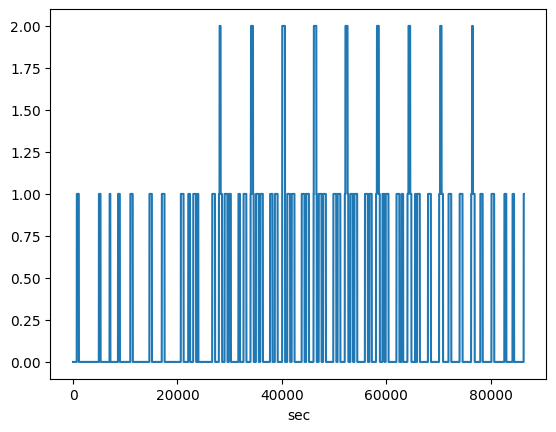

In [7]:
#a plot of how many satellites are risen 

#this gives a list of how many satellites are risen, where each entry represents a time interval
num_sats_risen = [len(x) for x in rsats]
#then you just plot it, noting that we have to multiply by 5 since that is our "dt" for the get_risen_sats
#i.e. the rate at which we measure how many sats there are
plt.plot(np.arange(len(rsats))*dt,num_sats_risen)
plt.xlabel("sec")
#plt.xlim(0,20000)


(0.0, 20000.0)

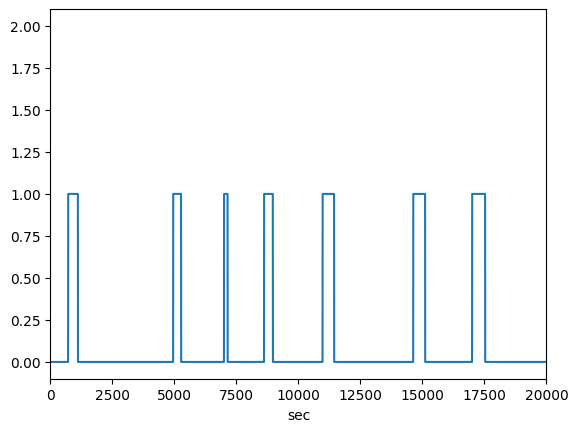

In [8]:
'''
same plot, but zoomed in
this is where he gets the 5*1000 initial timestamp from, because for the first chunk 
(which he uses to find the satellite offset) there is guaranteed to be only one satellite risen
you can clearly see this for the 5000 seconds (past 1721800002)
'''
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
plt.xlim(0,20000)

{44387, 59051, 57166, 28654, 33591, 25338}
[44387 59051 57166 28654 33591 25338]


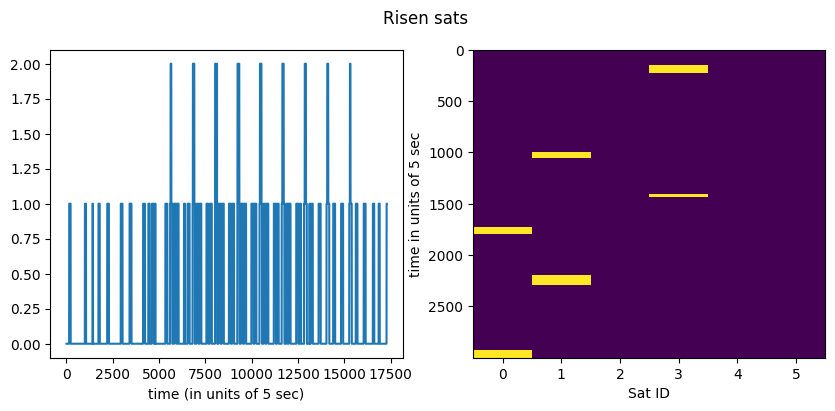

In [11]:
#satmap construction. Can see what satellites risen and when
num_sats_risen = [len(x) for x in rsats]
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

satids = set(satnums)
print(satids)
satlist = (np.array(list(satids)))
print(satlist)
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:3000],aspect='auto',interpolation="none")

Sat transits detected are: [[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]], [[4130, 4236], [0]], [[4414, 4485], [5]], [[4605, 4714], [1]], [[4775, 4801], [2]], [[5333, 5441], [0]], [[5589, 5615], [4]], [[5615, 5655], [4, 5]], [[5655, 5711], [5]], [[5808, 5916], [1]], [[5971, 6048], [2]], [[6337, 6397], [3]], [[6533, 6641], [0]], [[6801, 6817], [4]], [[6817, 6896], [4, 5]], [[6896, 6923], [5]], [[7008, 7116], [1]], [[7175, 7274], [2]], [[7549, 7642], [3]], [[7732, 7840], [0]], [[8018, 8123], [4, 5]], [[8209, 8318], [1]], [[8379, 8486], [2]], [[8762, 8870], [3]], [[8932, 9040], [0]], [[9226, 9323], [4, 5]], [[9323, 9338], [4]], [[9415, 9522], [1]], [[9582, 9690], [2]], [[9974, 10087], [3]], [[10138, 10243], [0]], [[10413, 10436], [5]], [[10436, 10520], [4, 5]], [[10520, 10548], [4]], [[10629, 10727], [1]], [[10782, 10889], [2]], [[11185, 11297], [3]], [[11355, 11447], [0]], [[11610, 11644], [5

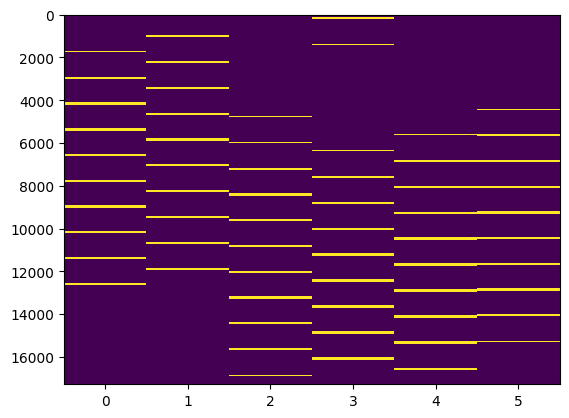

In [10]:
#get the pulses too
pulses = outils.get_simul_pulses(arr)
npulses = len(pulses)
print("Sat transits detected are:", pulses, '\n')
print("Number of Pulses:", npulses, '\n')
